# 적용 예정 모델

- Linear Regression
- RandomForestRegressor
- XGBoost Regressor
- SVR
- KNN Regressor

### Branch
1. BaseLine
2. RUL_Clipping
3. Scaling(Standard, MinMax, Robust)
4. 하이퍼 파라미터 튜닝

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# 한글 인코딩 문제 해결
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows

In [10]:
train = pd.read_csv(r'C:\Users\ASUS\.cache\kagglehub\datasets\behrad3d\nasa-cmaps\versions\1\CMaps\train_FD001.txt', sep=' ', header=None)
test = pd.read_csv(r'C:\Users\ASUS\.cache\kagglehub\datasets\behrad3d\nasa-cmaps\versions\1\CMaps\test_FD001.txt', sep=' ', header=None)
RUL = pd.read_csv(r'C:\Users\ASUS\.cache\kagglehub\datasets\behrad3d\nasa-cmaps\versions\1\CMaps\RUL_FD001.txt', sep=' ', header=None)
train.drop(columns=[26, 27], inplace=True)
test.drop(columns=[26, 27], inplace=True)
RUL.drop(columns=[1], inplace=True)

col_names = ['unit', 'cycle', 'setting_1', 'setting_2', 'setting_3', 'T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc', 'epr', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32']
train.columns = col_names
test.columns = col_names
RUL.columns = ['RUL']

In [11]:
# RUL 구하기
def get_RUL(df):
    rul_list = [x for x in df.groupby('unit')['cycle'].max()]
    for unit in df['unit'].unique():
        df.loc[df['unit']==unit, 'RUL'] = rul_list[unit-1] - df.loc[df['unit']==unit, 'cycle']

get_RUL(train)

In [12]:
train

,unit,cycle,setting_1,setting_2,setting_3,T2,T24,T30,T50,P2,...,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191.0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190.0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189.0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188.0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4.0
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3.0
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2.0
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1.0


- 전처리 1 : 제외할 만한 변동이 없는 컬럼 찾기

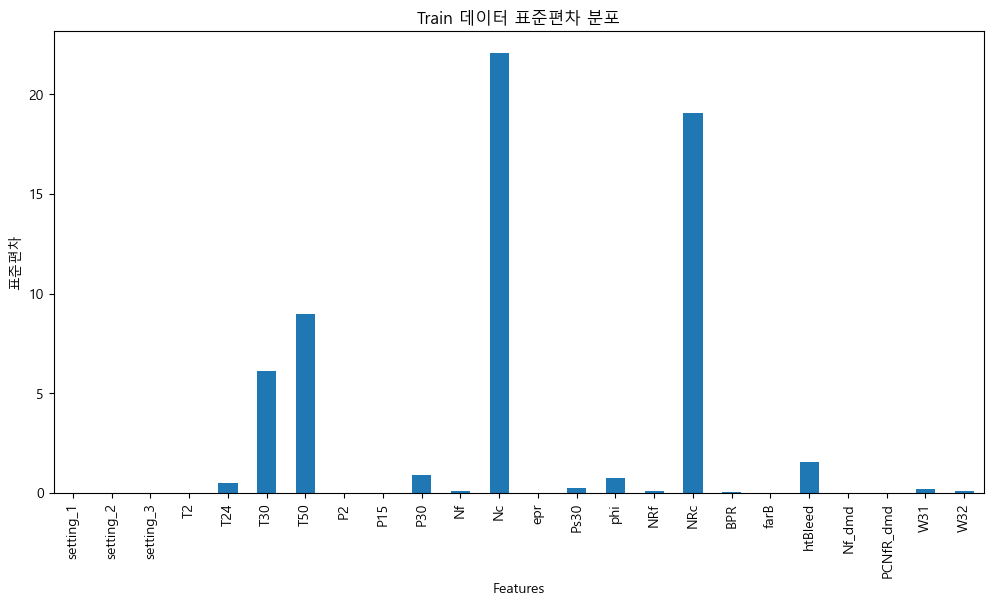

In [13]:
# 표준편차 분포로 제외할 만한 컬럼 찾기
plt.figure(figsize=(12,6))
std = train.drop(columns=['unit', 'cycle', 'RUL']).std()
std.plot(kind='bar')
plt.title('Train 데이터 표준편차 분포')
plt.xlabel('Features')
plt.ylabel('표준편차')
plt.show()

In [21]:
# 21가지 센서를 모두 적용하겠습니다.
features = train.columns[5:-1]
features

Index(['T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc', 'epr',
       'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'farB', 'htBleed', 'Nf_dmd',
       'PCNfR_dmd', 'W31', 'W32'],
      dtype='object')

---

In [19]:
# 시계열성을 따지지 않으므로 테스트셋의 마지막 사이클만 가져오기
test

,unit,cycle,setting_1,setting_2,setting_3,T2,T24,T30,T50,P2,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699


In [22]:
test.loc[test['unit'].isin(test['unit'].unique())].groupby('unit').last()[features].reset_index().drop(columns=['unit'])

,T2,T24,T30,T50,P2,P15,P30,Nf,Nc,epr,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
0,518.67,642.58,1581.22,1398.91,14.62,21.61,554.42,2388.08,9056.40,1.3,...,521.79,2388.06,8130.11,8.4024,0.03,393,2388,100.0,38.81,23.3552
1,518.67,642.55,1586.59,1410.83,14.62,21.61,553.52,2388.10,9044.77,1.3,...,521.74,2388.09,8126.90,8.4505,0.03,391,2388,100.0,38.81,23.2618
2,518.67,642.88,1589.75,1418.89,14.62,21.61,552.59,2388.16,9049.26,1.3,...,520.83,2388.14,8131.46,8.4119,0.03,395,2388,100.0,38.93,23.2740
3,518.67,642.78,1594.53,1406.88,14.62,21.61,552.64,2388.13,9051.30,1.3,...,521.88,2388.11,8133.64,8.4634,0.03,395,2388,100.0,38.58,23.2581
4,518.67,642.27,1589.94,1419.36,14.62,21.61,553.29,2388.10,9053.99,1.3,...,521.00,2388.15,8125.74,8.4362,0.03,394,2388,100.0,38.75,23.4117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,518.67,642.30,1590.88,1397.94,14.62,21.61,553.99,2388.03,9062.41,1.3,...,522.30,2388.01,8148.24,8.4110,0.03,391,2388,100.0,38.96,23.4606
96,518.67,642.59,1582.96,1410.92,14.62,21.61,554.05,2388.06,9076.36,1.3,...,521.58,2388.06,8155.48,8.4500,0.03,395,2388,100.0,38.61,23.2953
97,518.67,642.68,1599.51,1415.47,14.62,21.61,553.44,2388.13,9062.34,1.3,...,521.53,2388.09,8146.39,8.4235,0.03,394,2388,100.0,38.76,23.3608
98,518.67,642.00,1585.03,1397.98,14.62,21.61,554.75,2388.01,9067.16,1.3,...,521.82,2388.02,8150.38,8.4003,0.03,391,2388,100.0,38.95,23.3595


In [23]:
X_train = train[features]
y_train = train['RUL']
X_test = test.loc[test['unit'].isin(test['unit'].unique())].groupby('unit').last()[features].reset_index().drop(columns=['unit'])[features]
y_test = RUL

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(20631, 21) (20631,)
(100, 21) (100, 1)


1. 베이스라인

- 모델 적용해보기 (Random Forest, LinearRegression)

In [25]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

In [28]:
import os
os.environ['LOKY_MAX_CPU_COUNT'] = '4'

In [29]:
# 모델 정의
models1 = {
    'Linear Regression' : LinearRegression(n_jobs=-1),
    'Random Forest' : RandomForestRegressor(random_state=42, n_jobs=-1),
    'XGBoost' : XGBRegressor(random_State=42, n_jobs=-1),
    'SVR' : SVR(kernel='rbf'),
    'KNN' : KNeighborsRegressor(n_jobs=-1)
}

# 결과 저장 리스트
results1 = []

print("===베이스라인 모델===")

# 학습 실행

for name, model in models1.items():
    model.fit(X_train, y_train)

    pred = model.predict(X_test)

    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)

    # 결과 저장
    results1.append({
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'R2 Score': r2
    })

    print(f'{name} 완료, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2 Score: {r2:.4f}')

# 결과 표 출력
baseline_df = pd.DataFrame(results1).set_index('Model')
baseline_df = baseline_df.sort_values(by='RMSE', ascending=True).round(4)

print("\n===모델 성능 비교===")
print(baseline_df)

===베이스라인 모델===
Linear Regression 완료, RMSE: 31.9498, MAE: 25.5363, R2 Score: 0.4089
Random Forest 완료, RMSE: 34.6986, MAE: 24.9521, R2 Score: 0.3028
XGBoost 완료, RMSE: 41.0738, MAE: 26.9557, R2 Score: 0.0231
SVR 완료, RMSE: 49.7081, MAE: 39.0054, R2 Score: -0.4308
KNN 완료, RMSE: 36.3076, MAE: 28.0300, R2 Score: 0.2366

===모델 성능 비교===
                      RMSE      MAE  R2 Score
Model                                        
Linear Regression  31.9498  25.5363    0.4089
Random Forest      34.6986  24.9521    0.3028
KNN                36.3076  28.0300    0.2366
XGBoost            41.0738  26.9557    0.0231
SVR                49.7081  39.0054   -0.4308


---

- RUL Clipping

In [34]:
# y_train셋의 RUL 값을 120, 125, 130으로 클리핑하여 성능 비교
y_train_clipped_120 = y_train.clip(upper=120)
y_train_clipped_125 = y_train.clip(upper=125)
y_train_clipped_130 = y_train.clip(upper=130)

In [35]:
clip_list = [y_train_clipped_120, y_train_clipped_125, y_train_clipped_130]

In [46]:
# 모델 정의
models2 = {
    'Linear Regression' : LinearRegression(n_jobs=-1),
    'Random Forest' : RandomForestRegressor(random_state=42, n_jobs=-1),
    'XGBoost' : XGBRegressor(random_State=42, n_jobs=-1),
    'SVR' : SVR(kernel='rbf'),
    'KNN' : KNeighborsRegressor(n_jobs=-1)
}

# 학습 실행

for clip in clip_list:
    y_train = clip
    # 결과 저장 리스트
    results = []
    print(f"--- {clip.max()} ---")
    for name, model in models2.items():
        model.fit(X_train, y_train)

        pred = model.predict(X_test)

        mse = mean_squared_error(y_test, pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, pred)
        r2 = r2_score(y_test, pred)

        # 결과 저장
        results.append({
            'Model': name,
            'RMSE': rmse,
            'MAE': mae,
            'R2 Score': r2
        })

        print(f'{name} 완료, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2 Score: {r2:.4f}')

    # 결과 표 출력
    df = pd.DataFrame(results).set_index('Model')
    df = df.sort_values(by='RMSE', ascending=True).round(4)

    print("\n===모델 성능 비교===")
    print(df)

--- 120.0 ---
Linear Regression 완료, RMSE: 21.9226, MAE: 17.7643, R2 Score: 0.7217
Random Forest 완료, RMSE: 18.1167, MAE: 13.3496, R2 Score: 0.8099
XGBoost 완료, RMSE: 18.5077, MAE: 13.2504, R2 Score: 0.8016
SVR 완료, RMSE: 49.7081, MAE: 39.0054, R2 Score: -0.4308
KNN 완료, RMSE: 22.1103, MAE: 16.4400, R2 Score: 0.7169

===모델 성능 비교===
                      RMSE      MAE  R2 Score
Model                                        
Random Forest      18.1167  13.3496    0.8099
XGBoost            18.5077  13.2504    0.8016
Linear Regression  21.9226  17.7643    0.7217
KNN                22.1103  16.4400    0.7169
SVR                49.7081  39.0054   -0.4308
--- 125.0 ---
Linear Regression 완료, RMSE: 21.8947, MAE: 17.6153, R2 Score: 0.7224
Random Forest 완료, RMSE: 18.3008, MAE: 13.4527, R2 Score: 0.8061
XGBoost 완료, RMSE: 18.7233, MAE: 13.7375, R2 Score: 0.7970
SVR 완료, RMSE: 49.7081, MAE: 39.0054, R2 Score: -0.4308
KNN 완료, RMSE: 22.4651, MAE: 16.8960, R2 Score: 0.7077

===모델 성능 비교===
                    

---

- 스케일링 적용
    - RUL_Clipping : 125

In [51]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# 적용할 스케일러
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

# 모델 정의
models3 = {
    'Linear Regression': LinearRegression(n_jobs=-1),
    'Random Forest': RandomForestRegressor(random_state=42, n_jobs=-1),
    'XGBoost': XGBRegressor(random_state=42, n_jobs=-1),
    'SVR': SVR(kernel='rbf'),
    'KNN': KNeighborsRegressor(n_jobs=-1)
}

results3 = []

# 첫 번째 루프: 스케일러 적용
for scaler_name, scaler in scalers.items():
    print(f"--- [Scaling: {scaler_name}] ---")
    
    # 스케일링 수행 (Data Leakage 방지를 위해 Train으로 fit 후 Transform)
    # X_train, X_test 변수가 이미 정의되어 있다고 가정합니다.
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 두 번째 루프: 모델 학습 및 평가
    for model_name, model in models3.items():
        
        # 학습
        model.fit(X_train_scaled, y_train_clipped_125)
        
        # 예측
        pred = model.predict(X_test_scaled)
        
        # 평가
        mse = mean_squared_error(y_test, pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, pred)
        r2 = r2_score(y_test, pred)
        
        # 결과 저장 (어떤 스케일러인지 함께 기록)
        results3.append({
            'Scaler': scaler_name,
            'Model': model_name,
            'RMSE': rmse,
            'MAE': mae,
            'R2 Score': r2
        })
        
        print(f"   ✅ {model_name} 완료 (RMSE: {rmse:.4f})")
    print("") # 줄바꿈

# 4. 결과 표 출력
scaled_df = pd.DataFrame(results3)

# RMSE 기준으로 오름차순 정렬 (성능 좋은 순서대로 보기)
scaled_df = scaled_df.sort_values(by='RMSE', ascending=True).round(4)

print("\n" + "="*50)
print("🏆 최종 성능 비교표 (Top 10)")
print("="*50)
display(scaled_df)

--- [Scaling: StandardScaler] ---
   ✅ Linear Regression 완료 (RMSE: 21.8947)
   ✅ Random Forest 완료 (RMSE: 18.2695)
   ✅ XGBoost 완료 (RMSE: 18.7233)
   ✅ SVR 완료 (RMSE: 19.3333)
   ✅ KNN 완료 (RMSE: 18.5562)

--- [Scaling: MinMaxScaler] ---
   ✅ Linear Regression 완료 (RMSE: 21.8947)
   ✅ Random Forest 완료 (RMSE: 18.2994)
   ✅ XGBoost 완료 (RMSE: 18.7233)
   ✅ SVR 완료 (RMSE: 19.7762)
   ✅ KNN 완료 (RMSE: 18.5501)

--- [Scaling: RobustScaler] ---
   ✅ Linear Regression 완료 (RMSE: 21.8947)
   ✅ Random Forest 완료 (RMSE: 18.2694)
   ✅ XGBoost 완료 (RMSE: 18.7233)
   ✅ SVR 완료 (RMSE: 19.3033)
   ✅ KNN 완료 (RMSE: 19.1924)


🏆 최종 성능 비교표 (Top 10)


,Scaler,Model,RMSE,MAE,R2 Score
11,RobustScaler,Random Forest,18.2694,13.4278,0.8067
1,StandardScaler,Random Forest,18.2695,13.4322,0.8067
6,MinMaxScaler,Random Forest,18.2994,13.4476,0.8061
9,MinMaxScaler,KNN,18.5501,13.6760,0.8007
4,StandardScaler,KNN,18.5562,13.6660,0.8006
2,StandardScaler,XGBoost,18.7233,13.7375,0.7970
7,MinMaxScaler,XGBoost,18.7233,13.7375,0.7970
12,RobustScaler,XGBoost,18.7233,13.7375,0.7970
14,RobustScaler,KNN,19.1924,13.9020,0.7867
13,RobustScaler,SVR,19.3033,13.7044,0.7842
